# 28

hyperoptによるハイパラサーチ(ポアソン回帰)

In [19]:
import os
import pickle
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb

from sklearn.model_selection import train_test_split
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [20]:
from sklearn.decomposition import PCA

In [97]:
# ----------------------------------------- パラメータ
# 対象のモデル
model_type = 'model_vst'

# XGBoostのパラメータ
TS = 0.10   # CV中のtestサンプルの割合
NBR = 10000    # num_boost_round
ESR = 50    # early_stopping_rounds
NF = 3      # N_fold

best_param_normal = {'colsample_bylevel': 0.4199186332191585,
              'eta': 0.05279888407210238,
              'gamma': 0.9606545079165388,
              'max_delta_step': 0.8296741385893129,
              'max_depth': 8.0,
              'min_child_weight': 15.702027075472387,
              'reg_alpha': 2.7150954409503023,
              'reg_lambda': 1.9469597103665508,
              'subsample': 0.9598504881099209,
              'Nfold': NF}

best_param_poisson = {'colsample_bylevel': 0.788556202954217,
 'eta': 0.11132404187298267,
 'gamma': 4.917594988082049,
 'max_depth': 8.0,
 'min_child_weight': 15.316507490838852,
 'reg_alpha': 2.190976553473637,
 'reg_lambda': 1.2952348404765743,
 'subsample': 0.9375413551565218,
              'Nfold': NF}

---

## 関数の定義

In [22]:
# 抽出したサンプルの情報
def show_data_info(model_type, data):

    idx_istrain = data.type == 'train'

    n_train = sum(idx_istrain)
    n_id_train = data.loc[idx_istrain, :].air_store_id.unique().shape[0]
    n_test = sum(~idx_istrain)
    n_id_test = data.loc[~idx_istrain, :].air_store_id.unique().shape[0]

    print('')
    print('Model Pattern:', model_type)
    print('Train: Nsample: {},  Nid: {}'.format(n_train, n_id_train))
    print('Test : Nsample: {},  Nid: {}'.format(n_test, n_id_test))
    print('')

In [98]:
# XGBoostのモデル(最小二乗法)
def objective_xgb_normal(params):
    print('- XGBoost(Normal) ---------------------------------------------------------------')

    # CVの回数
    Nfold = int(params['Nfold'])

    # int型パラメータを修正
    params['max_depth'] = int(params['max_depth'])

    params['objective'] = 'reg:linear'
    params['eval_metric'] = 'rmse'

    # CV
    rmse_vec = np.zeros(Nfold)
    models = {}
    
    start = time.time()
    for loop in np.arange(0, Nfold, 1):
        # print(params)
        params['random_state'] = loop

        X_train, X_valid, y_train, y_valid, w_train, w_valid = train_test_split(X, y, w, test_size=TS, random_state=loop, shuffle=True)

        dtrain = xgb.DMatrix(data=X_train, label=y_train, weight=w_train)
        dvalid = xgb.DMatrix(data=X_valid, label=y_valid, weight=w_valid)
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

        model = xgb.train(params=params,
                          dtrain=dtrain,
                          num_boost_round=NBR,
                          evals=watchlist,
                          early_stopping_rounds=ESR,
                          verbose_eval=100)

        # early-stopping考慮の最適木数
        bst_iter = model.best_ntree_limit

        pred = model.predict(dvalid, ntree_limit = bst_iter)
        rmse_vec[loop] = np.sqrt(np.mean((pred - y_valid) ** 2))

        print('loop {} : {}'.format(loop, rmse_vec[loop]))

        models[loop] = model

    mean_rmse = np.mean(rmse_vec)
    
    elapsed_time = time.time() - start

    print('')
    print('mean_rmse : {}'.format(mean_rmse))
    print('elapsed_time:{0} [min]'.format(np.round(elapsed_time / 60., 3)))
    print('')

    ret = {'loss': mean_rmse,
           'status': STATUS_OK,
           'params': params,
           'rmse': mean_rmse,
           'model': models}

    return ret

In [24]:
# XGBoostのモデル(ポアソン回帰)
def objective_xgb_poisson(params):
    print('- XGBoost(Poisson) ---------------------------------------------------------------')

    # CVの回数
    Nfold = int(params['Nfold'])

    # int型パラメータを修正
    params['max_depth'] = int(params['max_depth'])

    params['objective'] = 'count:poisson'
    params['eval_metric'] = 'poisson-nloglik'#'rmse'

    # CV
    rmse_vec = np.zeros(Nfold)
    models = {}
    
    start = time.time()
    for loop in np.arange(0, Nfold, 1):
        # print(params)
        params['random_state'] = loop

        X_train, X_valid, y_train, y_valid, w_train, w_valid = train_test_split(X, y, w, test_size=TS, random_state=loop, shuffle=True)

        dtrain = xgb.DMatrix(data=X_train, label=y_train, weight=w_train)
        dvalid = xgb.DMatrix(data=X_valid, label=y_valid, weight=w_valid)
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

        model = xgb.train(params=params,
                          dtrain=dtrain,
                          num_boost_round=NBR,
                          evals=watchlist,
                          early_stopping_rounds=ESR,
                          verbose_eval=False)
        
        # early-stopping考慮の最適木数
        bst_iter = model.best_ntree_limit

        pred = model.predict(dvalid, ntree_limit = bst_iter)
        rmse_vec[loop] = np.sqrt(np.mean((np.log1p(pred) - np.log1p(y_valid)) ** 2))

        print('loop {} : {}'.format(loop, rmse_vec[loop]))

        models[loop] = model

    mean_rmse = np.mean(rmse_vec)
    
    elapsed_time = time.time() - start

    print('')
    print('mean_rmse : {}'.format(mean_rmse))
    print('elapsed_time:{0} [min]'.format(np.round(elapsed_time / 60., 3)))
    print('')

    ret = {'loss': mean_rmse,
           'status': STATUS_OK,
           'params': params,
           'rmse': mean_rmse,
           'model': models}

    return ret

In [25]:
# データ読み込み
def read_datas():

    # weight
    data_weight = pd.read_csv('./weight.csv')

    # train
    data_train = pd.read_csv('./train.csv')
    data_train = pd.merge(data_train, data_weight, on=['air_store_id', 'visit_date'])
    data_train['type'] = 'train'

    # test
    data_test = pd.read_csv('./test.csv')
    data_test['type'] = 'test'

    # rootデータ
    # 後段の処理を考えてマージしておく
    data_org = pd.concat([data_train, data_test])
    df_columns = pd.read_csv('./column_list.csv')

    print('Current Directory:', os.getcwd())
    print('train shape:', data_train.shape)
    print('test  shape:', data_test.shape)
    print('total shape:', data_org.shape)

    return data_org, df_columns

---

## データ読み込み

In [86]:
data_org, df_columns = read_datas()

Current Directory: /Users/shunsukeakita/Park/RecruitRVF/submit/32_180204_01
train shape: (252108, 98)
test  shape: (32019, 97)
total shape: (284127, 98)


---

## データ整形

### モデル別サンプル抽出

In [87]:
# モデルで使用する列名
usecols = list(df_columns[df_columns[model_type] == 1].colnm)
usecols.append('type')
usecols.append('id')
usecols.append('weight')
usecols.append('air_store_id')

In [88]:
# モデル別にサンプルを抽出する
data = data_org.copy()
if model_type == 'model_vst':
    idx = data.flg_vst == 1
    data = data.loc[idx, usecols]
elif model_type == 'model_vst_air':
    idx = data.flg_vst_air == 1
    data = data.loc[idx, usecols]
elif model_type == 'model_vst_hpg':
    idx = data.flg_vst_hpg == 1
    data = data.loc[idx, usecols]
elif model_type == 'model_vst_air_hpg':
    idx = data.flg_vst_air_hpg == 1
    data = data.loc[idx, usecols]
show_data_info(model_type, data)  # 抽出データの情報

/Users/shunsukeakita/Park/R/mainenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """
/Users/shunsukeakita/Park/R/mainenv/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)



Model Pattern: model_vst
Train: Nsample: 225013,  Nid: 828
Test : Nsample: 32019,  Nid: 821



### one-hot encoding

In [89]:
print('one-hot categorizing...')
# one-hot化する変数
onehotcols = list(df_columns[(df_columns[model_type] == 1) & (df_columns.type == 'factor')].colnm)
for nm in onehotcols:
    print(nm)
    temp = pd.get_dummies(data[nm], drop_first=False, prefix=nm)
    data = pd.concat([data, temp], axis=1)
print('')

onehotcols.append('holiday_weekday')
data = data.drop(axis=1, columns=onehotcols)

one-hot categorizing...
month_vst
holiday



In [90]:
data.shape

(257032, 85)

---

## ハイパラサーチ

In [ ]:
data_backup = data.copy()

In [ ]:
for imax in np.arange(3, 24, 1):
    col_PC = []
    for i in np.arange(1,imax,1):
        col_PC = np.append(col_PC, ['PC' + str(24 - i)])
        
    # ----------------------------------------- モデル構築
    # trainとtestを再度分割する
    idx = data.type == 'train'

    train = data.loc[idx, :].drop(axis = 1, columns=col_PC)
    X = train.drop(axis=1, columns=['visitors', 'type', 'id', 'weight', 'air_store_id'])
    y = np.log1p(train.visitors)
    w = train.weight

    test = data.loc[~idx, :].drop(axis = 1, columns=col_PC)
    X_test = test.drop(axis=1, columns=['visitors', 'type', 'id', 'weight', 'air_store_id'])
    y_test = test.loc[:, ['id', 'visitors']]
    
    print(col_PC)
    ret = objective_xgb_normal(best_param_normal)

In [ ]:
for imax in np.arange(1, 24, 1):
    col_PC = []
    for i in np.arange(1,imax,1):
        col_PC = np.append(col_PC, ['PC' + str(24 - i)])
        
    # ----------------------------------------- モデル構築
    # trainとtestを再度分割する
    idx = data.type == 'train'

    train = data.loc[idx, :].drop(axis = 1, columns=col_PC)
    X = train.drop(axis=1, columns=['visitors', 'type', 'id', 'weight', 'air_store_id'])
    y = train.visitors
    w = train.weight

    test = data.loc[~idx, :].drop(axis = 1, columns=col_PC)
    X_test = test.drop(axis=1, columns=['visitors', 'type', 'id', 'weight', 'air_store_id'])
    y_test = test.loc[:, ['id', 'visitors']]
    
    print(col_PC)
    ret = objective_xgb_poisson(best_param_poisson)

ここから

In [91]:
data.columns

Index(['visitors', 'islargeStore', 'isSmallStore', 'trend_log',
       'cmean_logtr_vst_365', 'cmed_logtr_vst_365', 'cp05_logtr_vst_365',
       'cp95_logtr_vst_365', 'cmean_logtr_vst_60', 'cmed_logtr_vst_60',
       'cp05_logtr_vst_60', 'cp95_logtr_vst_60', 'cmean_logtr_vst_wday24',
       'cmed_logtr_vst_wday24', 'cp05_logtr_vst_wday24',
       'cp95_logtr_vst_wday24', 'cmean_logtr_vst_wday12',
       'cmed_logtr_vst_wday12', 'latitude_air', 'longitude_air',
       'maxdiff_lat_air', 'maxdiff_lon_air', 'sum_lat_lon_air', 'islunch',
       'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'air_store_id_bin1', 'air_store_id_bin2', 'air_store_id_bin3',
       'air_store_id_bin4', 'air_store_id_bin5', 'air_store_id_bin6',
       'air_store_id_bin7', 'air_store_id_bin8', 'air_store_id_bin9',
       'air_store_id_bin10', 'day_vst_bin1', 'day_vst_bin2', 'day_vst_bin3',
       '

In [92]:
col_PC = []
for i in np.arange(1,15,1):
    col_PC = np.append(col_PC, ['PC' + str(21 - i)])

# ----------------------------------------- モデル構築
# trainとtestを再度分割する
idx = data.type == 'train'

train = data.loc[idx, :].drop(axis = 1, columns=col_PC)
X = train.drop(axis=1, columns=['visitors', 'type', 'id', 'weight', 'air_store_id'])
y = train.visitors
w = train.weight

test = data.loc[~idx, :].drop(axis = 1, columns=col_PC)
X_test = test.drop(axis=1, columns=['visitors', 'type', 'id', 'weight', 'air_store_id'])
y_test = test.loc[:, ['id', 'visitors']]

print(col_PC)

['PC20' 'PC19' 'PC18' 'PC17' 'PC16' 'PC15' 'PC14' 'PC13' 'PC12' 'PC11'
 'PC10' 'PC9' 'PC8' 'PC7']


In [93]:
# ret_p = objective_xgb_poisson(best_param_poisson)

In [94]:
X.columns

Index(['islargeStore', 'isSmallStore', 'trend_log', 'cmean_logtr_vst_365',
       'cmed_logtr_vst_365', 'cp05_logtr_vst_365', 'cp95_logtr_vst_365',
       'cmean_logtr_vst_60', 'cmed_logtr_vst_60', 'cp05_logtr_vst_60',
       'cp95_logtr_vst_60', 'cmean_logtr_vst_wday24', 'cmed_logtr_vst_wday24',
       'cp05_logtr_vst_wday24', 'cp95_logtr_vst_wday24',
       'cmean_logtr_vst_wday12', 'cmed_logtr_vst_wday12', 'latitude_air',
       'longitude_air', 'maxdiff_lat_air', 'maxdiff_lon_air',
       'sum_lat_lon_air', 'islunch', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6',
       'air_store_id_bin1', 'air_store_id_bin2', 'air_store_id_bin3',
       'air_store_id_bin4', 'air_store_id_bin5', 'air_store_id_bin6',
       'air_store_id_bin7', 'air_store_id_bin8', 'air_store_id_bin9',
       'air_store_id_bin10', 'day_vst_bin1', 'day_vst_bin2', 'day_vst_bin3',
       'day_vst_bin4', 'day_vst_bin5', 'air_genre_name_bin1',
       'air_genre_name_bin2', 'air_genre_name_bin3', 'air_genre_name_bin4',
     

In [95]:
y = np.log1p(train.visitors)

In [99]:
ret_n = objective_xgb_normal(best_param_normal)

- XGBoost(Normal) ---------------------------------------------------------------
[0]	train-rmse:2.38553	eval-rmse:2.38216
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[100]	train-rmse:0.48367	eval-rmse:0.502171
[200]	train-rmse:0.468433	eval-rmse:0.495082
[300]	train-rmse:0.46157	eval-rmse:0.494108
[400]	train-rmse:0.455829	eval-rmse:0.493546
[500]	train-rmse:0.451146	eval-rmse:0.493341
[600]	train-rmse:0.446956	eval-rmse:0.493162
[700]	train-rmse:0.443686	eval-rmse:0.492975
Stopping. Best iteration:
[704]	train-rmse:0.443567	eval-rmse:0.492939

loop 0 : 0.4937602330614657
[0]	train-rmse:2.38532	eval-rmse:2.38409
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[100]	train-rmse:0.484217	eval-rmse:0.495736
[200]	train-rmse:0.470018	eval-rmse:0.48968
[300]	train-rmse:0.462416	eval-rmse:0.488539
[40

---

予測結果を出力する

In [100]:
y_test_n = y_test.copy()
y_test_p = y_test.copy()
dtest = xgb.DMatrix(data=X_test)

正規分布

In [101]:
for i in np.arange(0, NF, 1):
    model = ret_n['model'][i]
    bst_iter = model.best_ntree_limit
    y_test_n.visitors += model.predict(dtest, ntree_limit = bst_iter)
    
y_test_n.visitors = y_test_n.visitors / NF
y_test_n.visitors = np.exp(y_test_n.visitors) - 1
y_test_n.visitors = y_test_n.visitors.map(lambda x: x if x >= 1 else 1)

ポアソン分布

In [21]:
for i in np.arange(0, NF, 1):
    model = ret_p['model'][i]
    bst_iter = model.best_ntree_limit
    y_test_p.visitors += model.predict(dtest, ntree_limit = bst_iter)
    
y_test_p.visitors = y_test_p.visitors / NF
y_test_p.visitors = y_test_p.visitors.map(lambda x: x if x >= 1 else 1)

In [24]:
os.getcwd()

'/Users/shunsukeakita/Park/RecruitRVF/submit/31_180201_01'

In [103]:
y_test_n.to_csv('./submission32.csv', index=False)

In [26]:
# y_test_p.to_csv('./submission29.csv', index=False)

In [27]:
# y_test.visitors = y_test_n.visitors * 0.6 + y_test_p.visitors * 0.4
# y_test_p.to_csv('./submission30.csv', index=False)

In [102]:
y_test_n.head(15)

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,8.015003
1,air_00a91d42b08b08d9_2017-04-24,21.576648
2,air_00a91d42b08b08d9_2017-04-25,26.151662
3,air_00a91d42b08b08d9_2017-04-26,27.725986
4,air_00a91d42b08b08d9_2017-04-27,32.199541
5,air_00a91d42b08b08d9_2017-04-28,35.426280
6,air_00a91d42b08b08d9_2017-04-29,13.449346
7,air_00a91d42b08b08d9_2017-04-30,7.447475
8,air_00a91d42b08b08d9_2017-05-01,21.919561
9,air_00a91d42b08b08d9_2017-05-02,27.287856


In [29]:
y_test_p.head(15)

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,7.591593
1,air_00a91d42b08b08d9_2017-04-24,23.609327
2,air_00a91d42b08b08d9_2017-04-25,26.428853
3,air_00a91d42b08b08d9_2017-04-26,28.083123
4,air_00a91d42b08b08d9_2017-04-27,31.968697
5,air_00a91d42b08b08d9_2017-04-28,37.166963
6,air_00a91d42b08b08d9_2017-04-29,12.874115
7,air_00a91d42b08b08d9_2017-04-30,7.497509
8,air_00a91d42b08b08d9_2017-05-01,24.521308
9,air_00a91d42b08b08d9_2017-05-02,29.776352


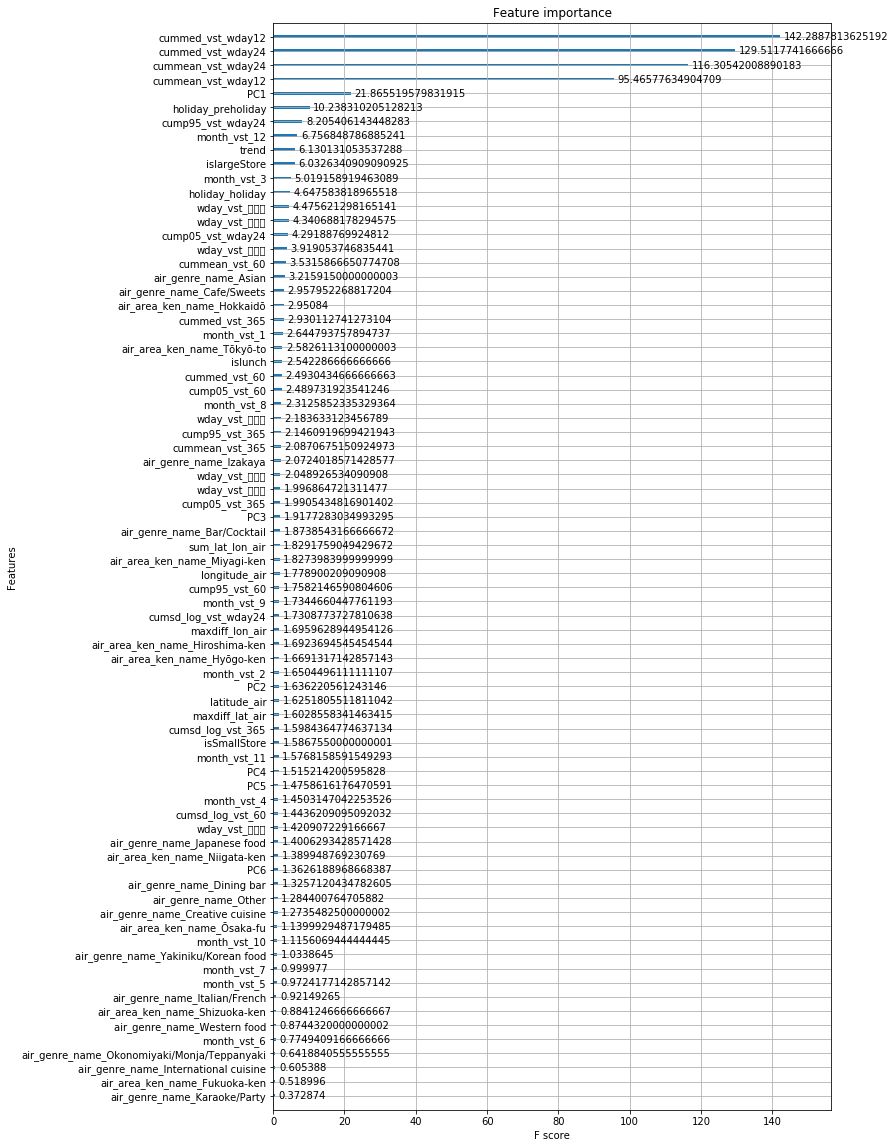

In [33]:
fig, ax = plt.subplots(figsize=(10,20))
xgb.plot_importance(ret_n['model'][0], ax=ax, importance_type='gain')

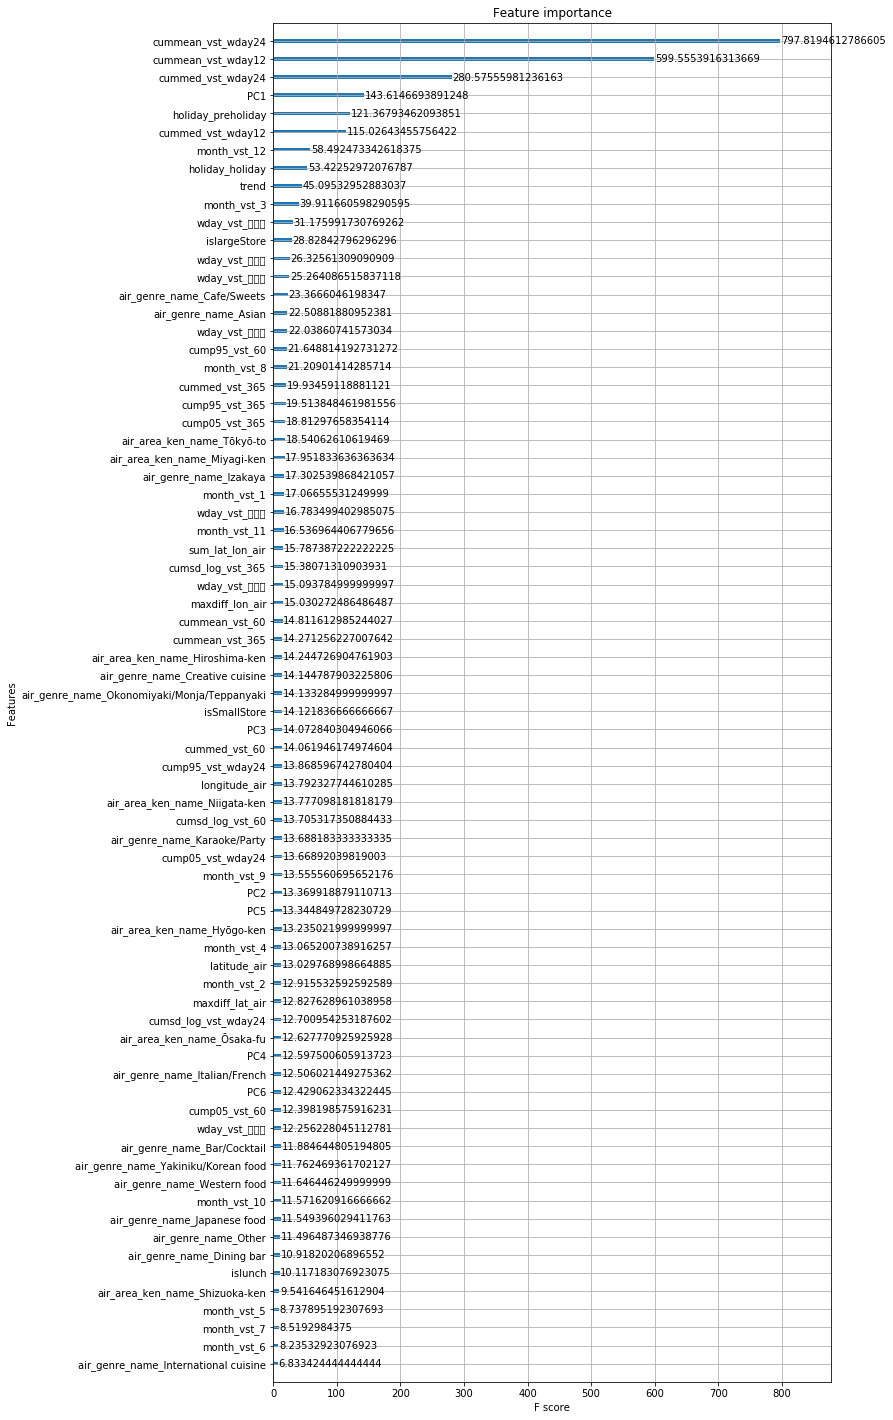

In [23]:
fig, ax = plt.subplots(figsize=(10,25))
xgb.plot_importance(ret_p['model'][0], ax=ax, importance_type='gain')